# Preliminaries

This commands are used in Google Colab:

!pip install deap

from google.colab import drive
drive.mount("/content/gdrive")

Importing python packages and setting display parameters

In [1]:
import math as mt
import random as rnd
import numpy as np
import itertools as it

import numba
from numba import jit
import joblib

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter
from matplotlib import lines

import pandas as pd
from collections import OrderedDict
import statistics as stats
import scipy.stats as sstats
import probscale

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = "retina"

plt.style.use("default")
plt.style.use("bmh")
# plt.rcParams.update({"figure.autolayout": True})
plt.rcParams["figure.figsize"] = (12, 9)
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 100

In [ ]:
pd.set_option("display.latex.repr", True)
pd.set_option("display.latex.longtable", True)

This sets the work directory for the pickle files

In [3]:
pickle_dir = "./pickle/"
file_sufix = "C_04"
pickle_dir + file_sufix

'./pickle/C_04'

Run this when working in Google Colab:

pickle_dir = "/content/gdrive/My Drive/Colab Notebooks/thesis/"
pickle_dir + file_sufix

# Reading data

## Fitness results data

Reading the Data Frame from a pickle file

In [4]:
fit_fin_df_file = pickle_dir + file_sufix + "_fit_fin_df_80k.xz"
fit_res_df = pd.read_pickle(fit_fin_df_file)

Replicates in the sample

In [5]:
print("Replicates in sample: " + str(len(fit_res_df)))
print("Experiments in sample: " + str(len(fit_res_df) / 40))

Replicates in sample: 5120
Experiments in sample: 128.0


In [79]:
fit_res_df.head()

,exp,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,rep,seed,births,avg,best,med,std,worst
0,1,20,0.6,0.1,0.1,0.5,2,2,1,654,80000,6.090422,6.08491,6.08491,0.02465,6.195148
1,1,20,0.6,0.1,0.1,0.5,2,2,2,654,80000,6.090422,6.08491,6.08491,0.02465,6.195148
2,1,20,0.6,0.1,0.1,0.5,2,2,3,654,80000,6.090422,6.08491,6.08491,0.02465,6.195148
3,1,20,0.6,0.1,0.1,0.5,2,2,4,654,80000,6.090422,6.08491,6.08491,0.02465,6.195148
4,1,20,0.6,0.1,0.1,0.5,2,2,5,654,80000,6.090422,6.08491,6.08491,0.02465,6.195148


# Experiment's factors and levels and other parameters

## Common parameters

In [7]:
# Algorithm parameters
# Number of replicates, and generations per experiment
rep_end = 40
births_end = 80e3

# Genes
gen_size = 2
# Population size
pop_size_lvl = [20, 160]
# Progeny and parents size ratio to population size
b_ratio_lvl = [0.6, 5]

# Progeny parameters
## Crossover probability per gene
cx_pb_lvl = [0.1, 0.9]
## Mutation probability per gene
mut_pb_lvl = [0.1, 0.9]
## Mutation strength
mut_sig_lvl = [0.5, 7.5]

# Selection by tournament
# Tournament size parent selection
k_par_lvl = [2, 6]
# Tournament size survivor selection
k_sur_lvl = [2, 6]

## Factor levels

In [8]:
factors_levels = [
    ("pop", "Population size", "Integer +", min(pop_size_lvl), max(pop_size_lvl)),
    ("b_ratio", "Progeny-to-pop ratio", "Real +", min(b_ratio_lvl), max(b_ratio_lvl)),
    ("cx_pb", "Crossover prob", "Real [0,1]", min(cx_pb_lvl), max(cx_pb_lvl)),
    ("mut_pb", "Mutation prob", "Real [0,1]", min(mut_pb_lvl), max(mut_pb_lvl)),
    ("mut_sig", "Mutation sigma", "Real +", min(mut_sig_lvl), max(mut_sig_lvl)),
    ("k_par", "Parent tourn size", "Integer +", min(k_par_lvl), max(k_par_lvl)),
    ("k_sur", "Surviv tourn size", "Integer +", min(k_sur_lvl), max(k_sur_lvl)),
]

factors_df = pd.DataFrame(
    factors_levels, columns=["Factor", "Label", "Range", "LowLevel", "HighLevel"]
)
factors_df = factors_df.set_index(["Factor"])

factors_df

,Label,Range,LowLevel,HighLevel
Factor,,,,
pop,Population size,Integer +,20.0,160.0
b_ratio,Progeny-to-pop ratio,Real +,0.6,5.0
cx_pb,Crossover prob,"Real [0,1]",0.1,0.9
mut_pb,Mutation prob,"Real [0,1]",0.1,0.9
mut_sig,Mutation sigma,Real +,0.5,7.5
k_par,Parent tourn size,Integer +,2.0,6.0
k_sur,Surviv tourn size,Integer +,2.0,6.0


In [9]:
factors_df.to_latex()

'\\begin{tabular}{lllrr}\n\\toprule\n{} &                 Label &       Range &  LowLevel &  HighLevel \\\\\nFactor  &                       &             &           &            \\\\\n\\midrule\npop     &       Population size &   Integer + &      20.0 &      160.0 \\\\\nb\\_ratio &  Progeny-to-pop ratio &      Real + &       0.6 &        5.0 \\\\\ncx\\_pb   &        Crossover prob &  Real [0,1] &       0.1 &        0.9 \\\\\nmut\\_pb  &         Mutation prob &  Real [0,1] &       0.1 &        0.9 \\\\\nmut\\_sig &        Mutation sigma &      Real + &       0.5 &        7.5 \\\\\nk\\_par   &     Parent tourn size &   Integer + &       2.0 &        6.0 \\\\\nk\\_sur   &     Surviv tourn size &   Integer + &       2.0 &        6.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

# DOE Analisis of Data

List with the Factors names

In [10]:
factors = list(factors_df.index.array)
print(factors)
factors_DOE = [factor + "_DOE" for factor in factors]
print(factors_DOE)

['pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur']
['pop_DOE', 'b_ratio_DOE', 'cx_pb_DOE', 'mut_pb_DOE', 'mut_sig_DOE', 'k_par_DOE', 'k_sur_DOE']


In [11]:
print(len(fit_res_df))

5120


In [12]:
fit_success = fit_res_df.assign(success=fit_res_df.best.le(1e-6))
fit_success = fit_success.groupby(factors, as_index=False).agg({"success": np.sum})
print(len(fit_success))

128


In [13]:
fit_success_doe = fit_res_df.assign(success=fit_res_df.best.le(1e-6))
fit_success_doe = fit_success_doe.groupby(factors, as_index=False).agg(
    {"success": np.sum}
)
fit_success_doe.head(10)

,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,success
0,20,0.6,0.1,0.1,0.5,2,2,0.0
1,20,0.6,0.1,0.1,0.5,2,6,36.0
2,20,0.6,0.1,0.1,0.5,6,2,12.0
3,20,0.6,0.1,0.1,0.5,6,6,6.0
4,20,0.6,0.1,0.1,7.5,2,2,0.0
5,20,0.6,0.1,0.1,7.5,2,6,0.0
6,20,0.6,0.1,0.1,7.5,6,2,0.0
7,20,0.6,0.1,0.1,7.5,6,6,3.0
8,20,0.6,0.1,0.9,0.5,2,2,0.0
9,20,0.6,0.1,0.9,0.5,2,6,10.0


In [14]:
for factor in factors:
    fac_min = fit_success[factor].min()
    fac_max = fit_success[factor].max()

    fit_success[factor] = fit_success[factor].map(lambda v: -1 if v == fac_min else 1)

In [15]:
fit_success.head()

,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,success
0,-1,-1,-1,-1,-1,-1,-1,0.0
1,-1,-1,-1,-1,-1,-1,1,36.0
2,-1,-1,-1,-1,-1,1,-1,12.0
3,-1,-1,-1,-1,-1,1,1,6.0
4,-1,-1,-1,-1,1,-1,-1,0.0


## Defining variables and variable labels

In [16]:
labels = {}
labels[1] = list(factors)
for i in [2, 3, 4, 5, 6, 7]:
    labels[i] = list(it.combinations(labels[1], i))

obs_list = ["success"]

for k in labels.keys():
    print(str(k) + " : " + str(labels[k]))
print()
print(obs_list)

1 : ['pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur']
2 : [('pop', 'b_ratio'), ('pop', 'cx_pb'), ('pop', 'mut_pb'), ('pop', 'mut_sig'), ('pop', 'k_par'), ('pop', 'k_sur'), ('b_ratio', 'cx_pb'), ('b_ratio', 'mut_pb'), ('b_ratio', 'mut_sig'), ('b_ratio', 'k_par'), ('b_ratio', 'k_sur'), ('cx_pb', 'mut_pb'), ('cx_pb', 'mut_sig'), ('cx_pb', 'k_par'), ('cx_pb', 'k_sur'), ('mut_pb', 'mut_sig'), ('mut_pb', 'k_par'), ('mut_pb', 'k_sur'), ('mut_sig', 'k_par'), ('mut_sig', 'k_sur'), ('k_par', 'k_sur')]
3 : [('pop', 'b_ratio', 'cx_pb'), ('pop', 'b_ratio', 'mut_pb'), ('pop', 'b_ratio', 'mut_sig'), ('pop', 'b_ratio', 'k_par'), ('pop', 'b_ratio', 'k_sur'), ('pop', 'cx_pb', 'mut_pb'), ('pop', 'cx_pb', 'mut_sig'), ('pop', 'cx_pb', 'k_par'), ('pop', 'cx_pb', 'k_sur'), ('pop', 'mut_pb', 'mut_sig'), ('pop', 'mut_pb', 'k_par'), ('pop', 'mut_pb', 'k_sur'), ('pop', 'mut_sig', 'k_par'), ('pop', 'mut_sig', 'k_sur'), ('pop', 'k_par', 'k_sur'), ('b_ratio', 'cx_pb', 'mut_pb'), ('b_ratio', 'cx_pb'

## Computing Main and Interaction Effects

### Constant Effect

In [17]:
effects = {}

# Start with the constant effect: this is $\overline{y}$
effects[0] = {"x0": [fit_success[obs_list[0]].mean()]}
print(effects[0])

{'x0': [5.40625]}


### Main effect of each variable

In [18]:
effects[1] = {}
for key in labels[1]:
    effects_result = []
    for obs in obs_list:
        effects_df = fit_success.groupby(key)[obs].mean()
        result = sum([zz * effects_df.loc[zz] for zz in effects_df.index])
        effects_result.append(result)
    effects[1][key] = effects_result

effects[1]

{'pop': [4.375],
 'b_ratio': [-4.625],
 'cx_pb': [0.03125],
 'mut_pb': [-2.875],
 'mut_sig': [-10.25],
 'k_par': [-0.03125],
 'k_sur': [3.84375]}

### Interaction effects (2-variable to 6-variable interactions)

In [19]:
for c in range(2, 8):
    effects[c] = {}
    for key in labels[c]:
        effects_result = []
        for obs in obs_list:
            effects_df = fit_success.groupby(key)[obs].mean()
            result = sum(
                [
                    np.prod(zz) * effects_df.loc[zz] / (2 ** (len(zz) - 1))
                    for zz in effects_df.index
                ]
            )
            effects_result.append(result)
        effects[c][key] = effects_result

C:\Anaconda3\envs\ea_thesis\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


In [20]:
def printd(d):
    for k in d.keys():
        print("%25s : %s" % (k, d[k]))


for i in range(1, 8):
    printd(effects[i])

                      pop : [4.375]
                  b_ratio : [-4.625]
                    cx_pb : [0.03125]
                   mut_pb : [-2.875]
                  mut_sig : [-10.25]
                    k_par : [-0.03125]
                    k_sur : [3.84375]
       ('pop', 'b_ratio') : [-2.375]
         ('pop', 'cx_pb') : [0.03125]
        ('pop', 'mut_pb') : [0.5625]
       ('pop', 'mut_sig') : [-4.25]
         ('pop', 'k_par') : [0.53125]
         ('pop', 'k_sur') : [0.65625]
     ('b_ratio', 'cx_pb') : [0.21875]
    ('b_ratio', 'mut_pb') : [-1.625]
   ('b_ratio', 'mut_sig') : [4.25]
     ('b_ratio', 'k_par') : [0.46875]
     ('b_ratio', 'k_sur') : [0.09375]
      ('cx_pb', 'mut_pb') : [-0.28125]
     ('cx_pb', 'mut_sig') : [0.09375]
       ('cx_pb', 'k_par') : [-0.4375]
       ('cx_pb', 'k_sur') : [-0.3125]
    ('mut_pb', 'mut_sig') : [2.75]
      ('mut_pb', 'k_par') : [0.96875]
      ('mut_pb', 'k_sur') : [0.21875]
     ('mut_sig', 'k_par') : [0.21875]
     ('mut_sig', 'k_sur') 

## Analysis

### Analyzing Effects

In [21]:
master_dict = {}
for nvars in effects.keys():
    effect = effects[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict[k] = nvars, v[0]

master_df = pd.DataFrame(master_dict).T
master_df.columns = ["interaction"] + obs_list
master_df.head(15)

,interaction,success
x0,0.0,5.40625
pop,1.0,4.37500
b_ratio,1.0,-4.62500
cx_pb,1.0,0.03125
mut_pb,1.0,-2.87500
mut_sig,1.0,-10.25000
k_par,1.0,-0.03125
k_sur,1.0,3.84375
"(pop, b_ratio)",2.0,-2.37500
"(pop, cx_pb)",2.0,0.03125


We calculate the Percentage contribution of each main factor to the variance

In [22]:
n_doe = 1
k_doe = 7

y1 = master_df.copy()
y1 = y1.iloc[y1[obs_list[0]].abs().argsort].iloc[::-1]
y1 = y1.drop("x0")
y1.columns = ["Int Level", "Effect_Estimate"]
y1.index.names = ["Factors"]
y1["Sum_of_Squares"] = y1["Effect_Estimate"] ** 2 * n_doe * (2 ** (k_doe - 2))

Top Fifteen of Percentage contribution to the variance of Interactions

In [23]:
SS_tot = (fit_success[obs_list[0]] ** 2).sum() - (
    (fit_success[obs_list[0]].sum() ** 2) / len(fit_success[obs_list[0]])
)
SS_err = SS_tot - (y1["Sum_of_Squares"].sum())
y1["%_Contribution"] = y1["Sum_of_Squares"] / SS_tot * 100
effect_estimate = y1.copy()
effect_estimate.index.names = ["Interaction"]
effect_estimate.drop(["Int Level"], axis=1).head(15)

,Effect_Estimate,Sum_of_Squares,%_Contribution
Interaction,,,
mut_sig,-10.25000,3362.00000,34.606724
b_ratio,-4.62500,684.50000,7.045896
pop,4.37500,612.50000,6.304765
"(pop, mut_sig)",-4.25000,578.00000,5.949639
"(b_ratio, mut_sig)",4.25000,578.00000,5.949639
k_sur,3.84375,472.78125,4.866571
"(mut_sig, k_sur)",-3.71875,442.53125,4.555192
mut_pb,-2.87500,264.50000,2.722629
"(mut_pb, mut_sig)",2.75000,242.00000,2.491025


Top Ten of Percentage contribution to the variance of main interactions

In [24]:
query = effect_estimate["Int Level"] == 1
effect_estimate[query].drop(["Int Level"], axis=1)

,Effect_Estimate,Sum_of_Squares,%_Contribution
Interaction,,,
mut_sig,-10.25000,3362.00000,34.606724
b_ratio,-4.62500,684.50000,7.045896
pop,4.37500,612.50000,6.304765
k_sur,3.84375,472.78125,4.866571
mut_pb,-2.87500,264.50000,2.722629
k_par,-0.03125,0.03125,0.000322
cx_pb,0.03125,0.03125,0.000322


Top Ten of Percentage contribution to the variance of second-order interactions

In [25]:
query = effect_estimate["Int Level"] == 2
effect_estimate[query].drop(["Int Level"], axis=1).head(10)

,Effect_Estimate,Sum_of_Squares,%_Contribution
Interaction,,,
"(pop, mut_sig)",-4.25000,578.00000,5.949639
"(b_ratio, mut_sig)",4.25000,578.00000,5.949639
"(mut_sig, k_sur)",-3.71875,442.53125,4.555192
"(mut_pb, mut_sig)",2.75000,242.00000,2.491025
"(pop, b_ratio)",-2.37500,180.50000,1.857976
"(b_ratio, mut_pb)",-1.62500,84.50000,0.869800
"(mut_pb, k_par)",0.96875,30.03125,0.309126
"(k_par, k_sur)",-0.87500,24.50000,0.252191
"(pop, k_sur)",0.65625,13.78125,0.141857


Top Ten of Percentage contribution to the variance of third-order interactions

In [26]:
query = effect_estimate["Int Level"] == 3
effect_estimate[query].drop(["Int Level"], axis=1).head(10)

,Effect_Estimate,Sum_of_Squares,%_Contribution
Interaction,,,
"(b_ratio, mut_pb, k_sur)",-2.46875,195.03125,2.007553
"(pop, b_ratio, mut_sig)",2.43750,190.12500,1.957050
"(b_ratio, mut_pb, mut_sig)",1.56250,78.12500,0.804179
"(b_ratio, k_par, k_sur)",1.56250,78.12500,0.804179
"(mut_pb, k_par, k_sur)",1.43750,66.12500,0.680657
"(pop, b_ratio, k_sur)",1.21875,47.53125,0.489263
"(mut_pb, mut_sig, k_par)",-1.21875,47.53125,0.489263
"(mut_sig, k_par, k_sur)",1.12500,40.50000,0.416886
"(pop, k_par, k_sur)",0.93750,28.12500,0.289504


Percentage contribution of each Interaction level to the variance

In [27]:
y1.groupby(["Int Level"]).agg(
    OrderedDict(
        [
            ("Effect_Estimate", "count"),
            ("Sum_of_Squares", "sum"),
            ("%_Contribution", ["sum", "max", "min"]),
        ]
    )
).rename(columns={"Effect_Estimate": "Count", "sum": "total", "count": "total"})

Count Sum_of_Squares %_Contribution                     
          total          total          total        max       min
Int Level                                                         
1.0           7     5396.34375      55.547228  34.606724  0.000322
2.0          21     2217.00000      22.820674   5.949639  0.000322
3.0          35      988.34375      10.173510   2.007553  0.000322
4.0          35      733.37500       7.548991   1.809403  0.001287
5.0          21      238.53125       2.455320   0.371852  0.001287
6.0           7       98.50000       1.013909   0.540730  0.002895
7.0           1       42.78125       0.440369   0.440369  0.440369

### Main effects plot

Colors represent if factor is in the top 3 (green), top 5 (blue), top 10 (yellow)

In [28]:
effects_top_10 = effect_estimate.head(10).index.values.tolist()
effects_top_5 = effect_estimate.head(5).index.values.tolist()
effects_top_3 = effect_estimate.head(3).index.values.tolist()
query = effect_estimate["Int Level"] == 1
effect_level_1_ranked = effect_estimate[query].index.values.tolist()
query = effect_estimate["Int Level"] == 2
effect_level_2_ranked = effect_estimate[query].index.values.tolist()

print("Top 10 of effects with biggest impact:")
print(effects_top_10)
print("First level interactions sorted by impact:")
print(effect_level_1_ranked)
print("Secont level interactions sorted by impact:")
print(effect_level_2_ranked)

Top 10 of effects with biggest impact:
['mut_sig', 'b_ratio', 'pop', ('pop', 'mut_sig'), ('b_ratio', 'mut_sig'), 'k_sur', ('mut_sig', 'k_sur'), 'mut_pb', ('mut_pb', 'mut_sig'), ('b_ratio', 'mut_pb', 'k_sur')]
First level interactions sorted by impact:
['mut_sig', 'b_ratio', 'pop', 'k_sur', 'mut_pb', 'k_par', 'cx_pb']
Secont level interactions sorted by impact:
[('pop', 'mut_sig'), ('b_ratio', 'mut_sig'), ('mut_sig', 'k_sur'), ('mut_pb', 'mut_sig'), ('pop', 'b_ratio'), ('b_ratio', 'mut_pb'), ('mut_pb', 'k_par'), ('k_par', 'k_sur'), ('pop', 'k_sur'), ('pop', 'mut_pb'), ('pop', 'k_par'), ('b_ratio', 'k_par'), ('cx_pb', 'k_par'), ('cx_pb', 'k_sur'), ('cx_pb', 'mut_pb'), ('b_ratio', 'cx_pb'), ('mut_pb', 'k_sur'), ('mut_sig', 'k_par'), ('b_ratio', 'k_sur'), ('cx_pb', 'mut_sig'), ('pop', 'cx_pb')]


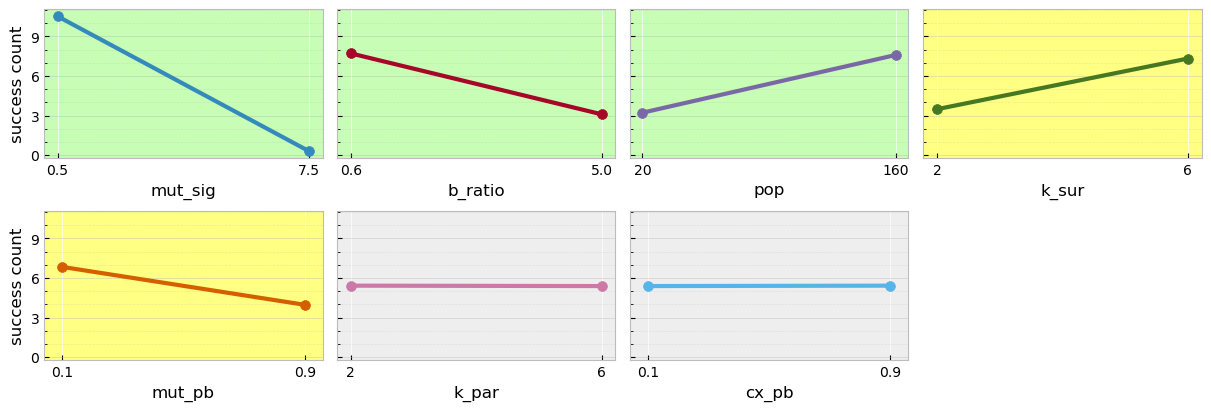

Wall time: 7.69 s


In [29]:
%%time
fig, axs = plt.subplots(
    nrows=2, ncols=4, sharey=True, constrained_layout=True, figsize=(12, 4)
)

for ax, i in zip(axs.flatten(), range(len(effect_level_1_ranked))):
    sns.regplot(
        x=effect_level_1_ranked[i],
        y="success",
        data=fit_success_doe,
        x_estimator=np.mean,
        x_ci=None,
        ci=None,
        truncate=True,
        ax=ax,
    )
    ax.set_ylabel(None)
    ax.set_axisbelow(True)
    x_majors = [
        fit_success_doe[effect_level_1_ranked[i]].min(),
        fit_success_doe[effect_level_1_ranked[i]].max(),
    ]
    ax.xaxis.set_major_locator(ticker.FixedLocator(x_majors))
    ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
    ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")

for ax, i in zip(axs.flatten(), range(len(effect_level_1_ranked))):
    if effect_level_1_ranked[i] in effects_top_10:
        ax.set_facecolor("xkcd:pale yellow")
    if effect_level_1_ranked[i] in effects_top_5:
        ax.set_facecolor("xkcd:pale blue")
    if effect_level_1_ranked[i] in effects_top_3:
        ax.set_facecolor("xkcd:pale green")

axs[0, 0].set_ylabel("success count")
axs[1, 0].set_ylabel("success count")

axs.flatten()[-1].axis("off")

plt.show()

### Interaction effects plot

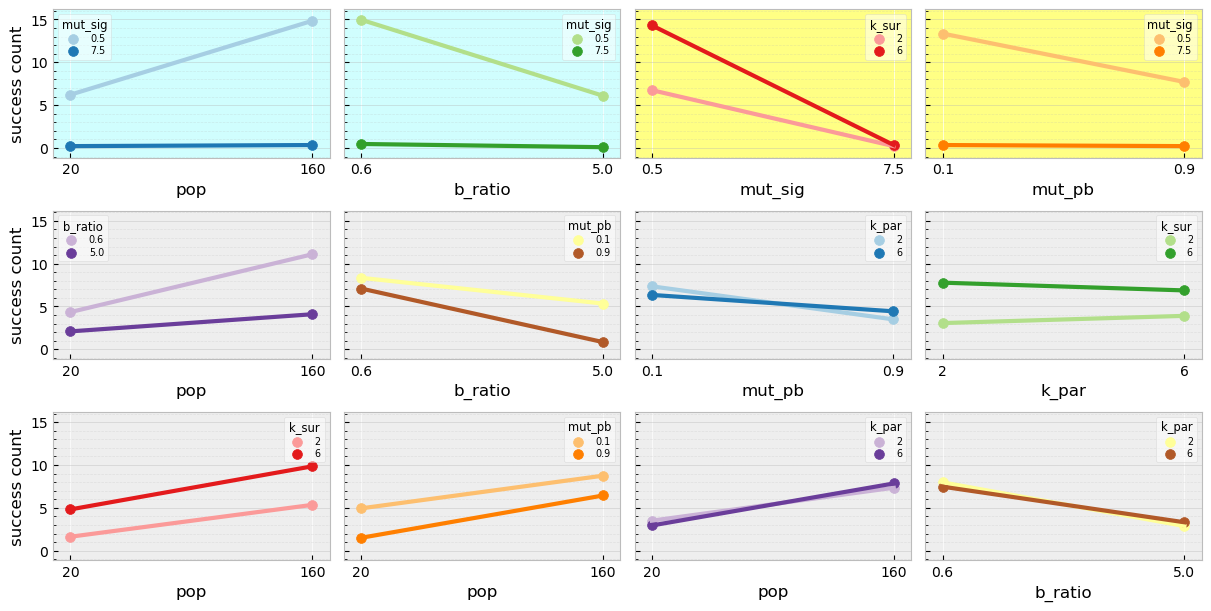

Wall time: 15.3 s


In [30]:
%%time
fig, axs = plt.subplots(
    nrows=3, ncols=4, sharey=True, constrained_layout=True, figsize=(12, 6)
)
# set palette
palette = it.cycle(sns.color_palette("Paired"))

for i, ax in enumerate(axs.flat):
    (a, b) = effect_level_2_ranked[i]
    c = next(palette)
    sns.regplot(
        x=a,
        y="success",
        data=fit_success_doe[fit_success_doe[b] == fit_success_doe[b].min()],
        label=str(fit_success_doe[b].min()),
        x_estimator=np.mean,
        color=c,
        x_ci=None,
        ci=None,
        truncate=True,
        ax=ax,
    )
    c = next(palette)
    sns.regplot(
        x=a,
        y="success",
        data=fit_success_doe[fit_success_doe[b] == fit_success_doe[b].max()],
        label=str(fit_success_doe[b].max()),
        x_estimator=np.mean,
        color=c,
        x_ci=None,
        ci=None,
        truncate=True,
        ax=ax,
    )
    ax.set_ylabel(None)
    ax.set_axisbelow(True)
    x_majors = [fit_success_doe[a].min(), fit_success_doe[a].max()]
    ax.xaxis.set_major_locator(ticker.FixedLocator(x_majors))
    ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
    ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")
    ax.legend(
        labelspacing=0.25,
        fontsize="x-small",
        title=str(b),
        title_fontsize="small",
        facecolor="white",
        framealpha=0.5,
    )
    if effect_level_2_ranked[i] in effects_top_10:
        ax.set_facecolor("xkcd:pale yellow")
    if effect_level_2_ranked[i] in effects_top_5:
        ax.set_facecolor("xkcd:pale blue")
    if effect_level_2_ranked[i] in effects_top_3:
        ax.set_facecolor("xkcd:pale green")

axs[0, 0].set_ylabel("success count")
axs[1, 0].set_ylabel("success count")
axs[2, 0].set_ylabel("success count")

plt.show()

### ANOVA Analysis

From unreplicated 7-level to 4-replicate 5-level

In [31]:
%%time
factors_5l = ["mut_sig", "b_ratio", "pop", "k_sur", "mut_pb"]
fit_success_5l = fit_res_df.assign(success=fit_res_df.best.le(1e-6))
fit_success_5l = fit_success_5l.groupby(factors, as_index=False).agg(
    {"success": np.sum}
)
fit_success_5l["success"] = fit_success_5l["success"]

Wall time: 78.1 ms


In [32]:
for factor in factors_5l:
    fac_min = fit_success_5l[factor].min()
    fac_max = fit_success_5l[factor].max()

    fit_success_5l[factor] = fit_success_5l[factor].map(
        lambda v: -1 if v == fac_min else 1
    )

labels_5l = {}
labels_5l[1] = list(factors_5l)
for i in [2, 3, 4, 5]:
    labels_5l[i] = list(it.combinations(labels_5l[1], i))

obs_list_5l = ["success"]

effects_5l = {}

effects_5l[0] = {"x0": [fit_success_5l[obs_list_5l[0]].mean()]}

effects_5l[1] = {}
for key in labels_5l[1]:
    effects_result = []
    for obs in obs_list_5l:
        effects_df = fit_success_5l.groupby(key)[obs].mean()
        result = sum([zz * effects_df.loc[zz] for zz in effects_df.index])
        effects_result.append(result)
    effects_5l[1][key] = effects_result

for c in range(2, 6):
    effects_5l[c] = {}
    for key in labels_5l[c]:
        effects_result = []
        for obs in obs_list_5l:
            effects_df = fit_success_5l.groupby(key)[obs].mean()
            result = sum(
                [
                    np.prod(zz) * effects_df.loc[zz] / (2 ** (len(zz) - 1))
                    for zz in effects_df.index
                ]
            )
            effects_result.append(result)
        effects_5l[c][key] = effects_result

C:\Anaconda3\envs\ea_thesis\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


In [33]:
master_dict_5l = {}
for nvars in effects_5l.keys():
    effect = effects_5l[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict_5l[k] = nvars, v[0]

In [34]:
master_df_5l = pd.DataFrame(master_dict_5l).T
master_df_5l.columns = ["interaction"] + obs_list_5l
master_df_5l.head(15)

,interaction,success
x0,0.0,5.40625
mut_sig,1.0,-10.25000
b_ratio,1.0,-4.62500
pop,1.0,4.37500
k_sur,1.0,3.84375
mut_pb,1.0,-2.87500
"(mut_sig, b_ratio)",2.0,4.25000
"(mut_sig, pop)",2.0,-4.25000
"(mut_sig, k_sur)",2.0,-3.71875
"(mut_sig, mut_pb)",2.0,2.75000


In [35]:
n_doe_5l = 4
k_doe_5l = 5

y1_5l = master_df_5l.copy()
y1_5l = y1_5l.iloc[y1_5l[obs_list_5l[0]].abs().argsort].iloc[::-1]
y1_5l = y1_5l.drop("x0")
y1_5l.columns = ["Int Level", "Effect_Estimate"]
y1_5l.index.names = ["Factors"]
y1_5l["Sum_of_Squares"] = (
    y1_5l["Effect_Estimate"] ** 2 * n_doe_5l * (2 ** (k_doe_5l - 2))
)

SS_tot_5l = (fit_success_5l[obs_list_5l[0]] ** 2).sum() - (
    (fit_success_5l[obs_list_5l[0]].sum() ** 2) / len(fit_success_5l[obs_list_5l[0]])
)
SS_err_5l = SS_tot_5l - (y1_5l["Sum_of_Squares"].sum())
y1_5l["%_Contribution"] = y1_5l["Sum_of_Squares"] / SS_tot * 100
effect_estimate_5l = y1_5l.copy()
effect_estimate_5l.index.names = ["Interaction"]
effect_estimate_5l.drop(["Int Level"], axis=1).head(15)

,Effect_Estimate,Sum_of_Squares,%_Contribution
Interaction,,,
mut_sig,-10.25000,3362.00000,34.606724
b_ratio,-4.62500,684.50000,7.045896
pop,4.37500,612.50000,6.304765
"(mut_sig, b_ratio)",4.25000,578.00000,5.949639
"(mut_sig, pop)",-4.25000,578.00000,5.949639
k_sur,3.84375,472.78125,4.866571
"(mut_sig, k_sur)",-3.71875,442.53125,4.555192
mut_pb,-2.87500,264.50000,2.722629
"(mut_sig, mut_pb)",2.75000,242.00000,2.491025


In [36]:
y1_5l.groupby(["Int Level"]).agg(
    OrderedDict(
        [
            ("Effect_Estimate", "count"),
            ("Sum_of_Squares", "sum"),
            ("%_Contribution", ["sum", "max", "min"]),
        ]
    )
).rename(columns={"Effect_Estimate": "Count", "sum": "total", "count": "total"})

Count Sum_of_Squares %_Contribution                     
          total          total          total        max       min
Int Level                                                         
1.0           5     5396.28125      55.546584  34.606724  2.722629
2.0          10     2131.25000      21.938007   5.949639  0.002895
3.0          10      577.68750       5.946422   2.007553  0.000322
4.0           5      236.62500       2.435698   1.809403  0.092963
5.0           1        9.03125       0.092963   0.092963  0.092963

ANOVA Analysis with F statistics (significance level 5%)

In [37]:
ANOVA_succ_5l = y1_5l.copy()
ANOVA_succ_5l = ANOVA_succ_5l.drop("Effect_Estimate", axis=1)

In [38]:
ANOVA_succ_5l["Dgrs. Freedom"] = 1
df_tot_5l = n_doe_5l * 2 ** k_doe_5l - 1
df_err_5l = 2 ** k_doe_5l * (n_doe_5l - 1)

In [39]:
ANOVA_succ_5l["Mean Sqrs"] = (
    ANOVA_succ_5l["Sum_of_Squares"] / ANOVA_succ_5l["Dgrs. Freedom"]
)
ms_err_5l = SS_err_5l / df_err_5l

ANOVA_succ_5l["F 0"] = ANOVA_succ_5l["Mean Sqrs"] / ms_err_5l
sig_level = 0.05
ANOVA_succ_5l["P-Value"] = 1 - sstats.f.cdf(ANOVA_succ_5l["F 0"], dfn=1, dfd=df_err_5l)
# ANOVA_succ_5l["F critical"] = stats.f.ppf(q=1 - sig_level, dfn=1, dfd=df_tot)
# ANOVA_succ_5l["Significant"] = ANOVA_succ_5l["F ratio"] > ANOVA_succ_5l["F critical"]

In [40]:
ANOVA_succ_5l.loc["Error"] = [
    "Err",
    SS_err_5l,
    SS_err_5l / SS_tot_5l * 100,
    df_err_5l,
    ms_err_5l,
    "",
    "",
]
ANOVA_succ_5l.loc["Total"] = [
    "Tot",
    SS_tot_5l,
    SS_tot_5l / SS_tot_5l * 100,
    df_tot_5l,
    "",
    "",
    "",
]
ANOVA_succ_5l.loc["Model"] = [
    "Mod",
    SS_tot_5l - SS_err_5l,
    (SS_tot_5l - SS_err_5l) / SS_tot_5l * 100,
    "",
    "",
    "",
    "",
]

In [41]:
ANOVA_succ_5l

,Int Level,Sum_of_Squares,%_Contribution,Dgrs. Freedom,Mean Sqrs,F 0,P-Value
Factors,,,,,,,
mut_sig,1,3362.00000,34.606724,1,3362,236.622,1.11022e-16
b_ratio,1,684.50000,7.045896,1,684.5,48.176,4.58604e-10
pop,1,612.50000,6.304765,1,612.5,43.1085,2.64691e-09
"(mut_sig, b_ratio)",2,578.00000,5.949639,1,578,40.6804,6.28141e-09
"(mut_sig, pop)",2,578.00000,5.949639,1,578,40.6804,6.28141e-09
k_sur,1,472.78125,4.866571,1,472.781,33.2749,9.74385e-08
"(mut_sig, k_sur)",2,442.53125,4.555192,1,442.531,31.1459,2.21254e-07
mut_pb,1,264.50000,2.722629,1,264.5,18.6158,3.88298e-05
"(mut_sig, mut_pb)",2,242.00000,2.491025,1,242,17.0323,7.83015e-05


In [42]:
ANOVA_succ_5l.groupby(["Int Level"]).agg(
    OrderedDict(
        [("Int Level", "count"), ("Sum_of_Squares", "sum"), ("%_Contribution", "sum")]
    )
).rename(columns={"Int Level": "Count", "sum": "total", "count": "total"})

,Count,Sum_of_Squares,%_Contribution
Int Level,,,
1.0,5,5396.28125,55.546584
2.0,10,2131.25000,21.938007
3.0,10,577.68750,5.946422
4.0,5,236.62500,2.435698
5.0,1,9.03125,0.092963
Err,1,1364.00000,14.040325
Mod,1,8350.87500,85.959675
Tot,1,9714.87500,100.000000


In [43]:
df_show = ANOVA_succ_5l.iloc[np.r_[-1, 0:10, -3, -2]]
df_show

,Int Level,Sum_of_Squares,%_Contribution,Dgrs. Freedom,Mean Sqrs,F 0,P-Value
Factors,,,,,,,
Model,Mod,8350.87500,85.959675,,,,
mut_sig,1,3362.00000,34.606724,1,3362,236.622,1.11022e-16
b_ratio,1,684.50000,7.045896,1,684.5,48.176,4.58604e-10
pop,1,612.50000,6.304765,1,612.5,43.1085,2.64691e-09
"(mut_sig, b_ratio)",2,578.00000,5.949639,1,578,40.6804,6.28141e-09
"(mut_sig, pop)",2,578.00000,5.949639,1,578,40.6804,6.28141e-09
k_sur,1,472.78125,4.866571,1,472.781,33.2749,9.74385e-08
"(mut_sig, k_sur)",2,442.53125,4.555192,1,442.531,31.1459,2.21254e-07
mut_pb,1,264.50000,2.722629,1,264.5,18.6158,3.88298e-05


### Normal probability plots of the effects

Quantify which effects are not normally distributed, to assist in identifying important variables.

C:\Anaconda3\envs\ea_thesis\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Anaconda3\envs\ea_thesis\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


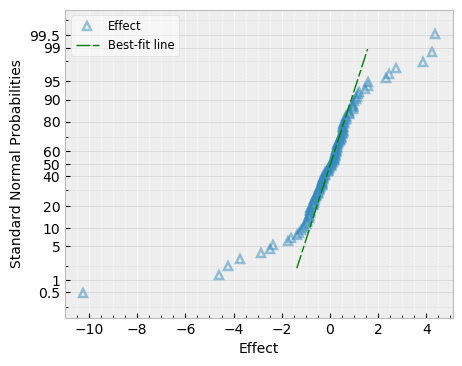

In [44]:
fig, ax = plt.subplots(figsize=(5, 4))
scatter_options_inv = dict(
    marker="^",
    markerfacecolor="none",
    markeredgewidth=1.75,
    linestyle="none",
    alpha=0,
    zorder=5,
)
scatter_options = dict(
    marker="^",
    markerfacecolor="none",
    markeredgewidth=1.75,
    linestyle="none",
    alpha=0.5,
    zorder=5,
    label="Effect",
)
line_options = dict(
    dashes=(10, 2, 5, 2), color="g", linewidth=1, zorder=10, label="Best-fit line"
)
fig = probscale.probplot(
    effect_estimate["Effect_Estimate"],
    ax=ax,
    plottype="prob",
    probax="y",
    problabel="Standard Normal Probabilities",
    datalabel="Effect",
    scatter_kws=scatter_options,
)
fig = probscale.probplot(
    effect_estimate["Effect_Estimate"].iloc[15:],
    ax=ax,
    plottype="prob",
    bestfit=True,
    probax="y",
    problabel="Standard Normal Probabilities",
    datalabel="Effect",
    scatter_kws=scatter_options_inv,
    line_kws=line_options,
)
y_majors = [0.5, 1, 5, 10, 20, 40, 50, 60, 80, 90, 95, 99, 99.5]
y_minors = [0.1, 0.2, 2, 30, 70, 98, 99.8, 99.9]
ax.legend(facecolor="white", fontsize="small", framealpha=0.5)
ax.yaxis.set_major_locator(ticker.FixedLocator(y_majors))
ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
ax.yaxis.set_minor_locator(ticker.FixedLocator(y_minors))
ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")
ax.set_ylabel("Standard Normal Probabilities", fontsize="medium")
ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.grid(True, axis="x", which="minor", alpha=0.75, color="w", ls="--")
ax.set_xlabel("Effect", fontsize="medium")
ax.set_axisbelow(True)
plt.show()

### Normal probability plot of residuals

In [45]:
fit_success.head()

,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,success
0,-1,-1,-1,-1,-1,-1,-1,0.0
1,-1,-1,-1,-1,-1,-1,1,36.0
2,-1,-1,-1,-1,-1,1,-1,12.0
3,-1,-1,-1,-1,-1,1,1,6.0
4,-1,-1,-1,-1,1,-1,-1,0.0


In [46]:
pred_c_0 = effects[0]["x0"][0]

pred_c_mut_sig = effects[1]["mut_sig"][0] / 2
pred_c_b_ratio = effects[1]["b_ratio"][0] / 2
pred_c_k_sur = effects[1]["k_sur"][0] / 2
pred_c_mut_pb = effects[1]["mut_pb"][0] / 2
pred_c_pop = effects[1]["pop"][0] / 2

pred_c_pop_mut_sig = effects[2][("pop", "mut_sig")][0] / 2
pred_c_b_ratio_mut_sig = effects[2][("b_ratio", "mut_sig")][0] / 2
pred_c_mut_sig_k_sur = effects[2][("mut_sig", "k_sur")][0] / 2
pred_c_mut_pb_mut_sig = effects[2][("mut_pb", "mut_sig")][0] / 2


def pred_1(b_ratio, cx_pb, mut_pb, mut_sig, k_par, k_sur):
    pred_1 = (
        pred_c_0
        + pred_c_mut_sig * mut_sig
        + pred_c_b_ratio * b_ratio
        + pred_c_k_sur * k_sur
        + pred_c_mut_pb * mut_pb
    )
    # Error con pop
    return pred_1


def pred_2(b_ratio, cx_pb, mut_pb, mut_sig, k_par, k_sur):
    pred_2 = (
        pred_c_b_ratio_mut_sig * b_ratio * mut_sig
        + pred_c_mut_sig_k_sur * mut_sig * k_sur
        + pred_c_mut_pb_mut_sig * mut_pb * mut_sig
    )
    # Error con pop
    return pred_2


fit_prediction = fit_success.copy().infer_objects()
fit_prediction["pred_1"] = fit_success.apply(
    lambda x: pred_1(x.b_ratio, x.cx_pb, x.mut_pb, x.mut_sig, x.k_par, x.k_sur), axis=1
)
fit_prediction["pred_1"] = fit_prediction["pred_1"] + fit_prediction["pop"] * pred_c_pop
fit_prediction = fit_prediction.assign(res_1=lambda x: x.success - x.pred_1)
fit_prediction["pred_2"] = fit_success.apply(
    lambda x: pred_2(x.b_ratio, x.cx_pb, x.mut_pb, x.mut_sig, x.k_par, x.k_sur), axis=1
)
fit_prediction["pred_2"] = fit_prediction["pred_2"] + fit_prediction["pred_1"]
fit_prediction["pred_2"] = (
    fit_prediction["pred_2"]
    + fit_prediction["pop"] * fit_prediction["mut_sig"] * pred_c_pop_mut_sig
)
fit_prediction = fit_prediction.assign(res_2=lambda x: x.success - x.pred_2)

fit_prediction.head()

,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,success,pred_1,res_1,pred_2,res_2
0,-1,-1,-1,-1,-1,-1,-1,0.0,10.171875,-10.171875,9.68750,-9.68750
1,-1,-1,-1,-1,-1,-1,1,36.0,14.015625,21.984375,17.25000,18.75000
2,-1,-1,-1,-1,-1,1,-1,12.0,10.171875,1.828125,9.68750,2.31250
3,-1,-1,-1,-1,-1,1,1,6.0,14.015625,-8.015625,17.25000,-11.25000
4,-1,-1,-1,-1,1,-1,-1,0.0,-0.078125,0.078125,0.40625,-0.40625


In [47]:
fit_prediction.head(7).to_latex()

'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} &  pop &  b\\_ratio &  cx\\_pb &  mut\\_pb &  mut\\_sig &  k\\_par &  k\\_sur &  success &     pred\\_1 &      res\\_1 &    pred\\_2 &     res\\_2 \\\\\n\\midrule\n0 &   -1 &       -1 &     -1 &      -1 &       -1 &     -1 &     -1 &      0.0 &  10.171875 & -10.171875 &   9.68750 &  -9.68750 \\\\\n1 &   -1 &       -1 &     -1 &      -1 &       -1 &     -1 &      1 &     36.0 &  14.015625 &  21.984375 &  17.25000 &  18.75000 \\\\\n2 &   -1 &       -1 &     -1 &      -1 &       -1 &      1 &     -1 &     12.0 &  10.171875 &   1.828125 &   9.68750 &   2.31250 \\\\\n3 &   -1 &       -1 &     -1 &      -1 &       -1 &      1 &      1 &      6.0 &  14.015625 &  -8.015625 &  17.25000 & -11.25000 \\\\\n4 &   -1 &       -1 &     -1 &      -1 &        1 &     -1 &     -1 &      0.0 &  -0.078125 &   0.078125 &   0.40625 &  -0.40625 \\\\\n5 &   -1 &       -1 &     -1 &      -1 &        1 &     -1 &      1 &      0.0 &   3.765625 &  -3.765625 &   0.53

In [48]:
fit_prediction.tail(7).to_latex()

'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} &  pop &  b\\_ratio &  cx\\_pb &  mut\\_pb &  mut\\_sig &  k\\_par &  k\\_sur &  success &     pred\\_1 &     res\\_1 &    pred\\_2 &     res\\_2 \\\\\n\\midrule\n121 &    1 &        1 &      1 &       1 &       -1 &     -1 &      1 &      1.0 &  10.890625 & -9.890625 &  11.37500 & -10.37500 \\\\\n122 &    1 &        1 &      1 &       1 &       -1 &      1 &     -1 &      0.0 &   7.046875 & -7.046875 &   3.81250 &  -3.81250 \\\\\n123 &    1 &        1 &      1 &       1 &       -1 &      1 &      1 &      6.0 &  10.890625 & -4.890625 &  11.37500 &  -5.37500 \\\\\n124 &    1 &        1 &      1 &       1 &        1 &     -1 &     -1 &      0.0 &  -3.203125 &  3.203125 &   0.03125 &  -0.03125 \\\\\n125 &    1 &        1 &      1 &       1 &        1 &     -1 &      1 &      0.0 &   0.640625 & -0.640625 &   0.15625 &  -0.15625 \\\\\n126 &    1 &        1 &      1 &       1 &        1 &      1 &     -1 &      0.0 &  -3.203125 &  3.203125 &  

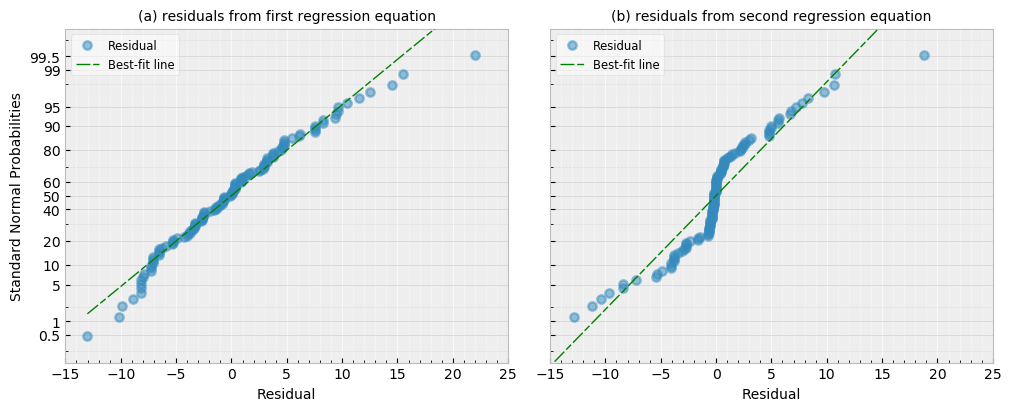

In [49]:
fig, axs = plt.subplots(figsize=(10, 4), ncols=2, sharex=True, constrained_layout=True)
# fig, ax = plt.subplots(figsize=(6,4.5))

scatter_options = dict(
    marker="o",
    markeredgewidth=1.75,
    linestyle="none",
    alpha=0.5,
    zorder=5,
    label="Residual",
)
line_options = dict(
    dashes=(10, 2, 5, 2), color="g", linewidth=1, zorder=10, label="Best-fit line"
)

fig = probscale.probplot(
    fit_prediction["res_1"],
    ax=axs[0],
    plottype="prob",
    probax="y",
    datalabel="Residual",
    bestfit=True,
    scatter_kws=scatter_options,
    line_kws=line_options,
)
fig = probscale.probplot(
    fit_prediction["res_2"],
    ax=axs[1],
    plottype="prob",
    probax="y",
    datalabel="Residual",
    bestfit=True,
    scatter_kws=scatter_options,
    line_kws=line_options,
)

y_majors = [0.5, 1, 5, 10, 20, 40, 50, 60, 80, 90, 95, 99, 99.5]
y_minors = [0.1, 0.2, 2, 30, 70, 98, 99.8, 99.9]

axs[0].set_title("(a) residuals from first regression equation", fontsize="medium")
axs[1].set_title("(b) residuals from second regression equation", fontsize="medium")
axs[0].set_ylabel("Standard Normal Probabilities", fontsize="medium")
axs[1].yaxis.set_ticklabels([])

for ax in axs.flat:
    ax.legend(facecolor="white", fontsize="small", framealpha=0.5)
    ax.yaxis.set_major_locator(ticker.FixedLocator(y_majors))
    ax.yaxis.set_minor_locator(ticker.FixedLocator(y_minors))
    ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
    ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
    ax.grid(True, axis="x", which="minor", alpha=0.75, color="w", ls="--")
    ax.set_xlabel("Residual", fontsize="medium")
    ax.set_xlim((-15, 25))
plt.show()

### Contour plots of predicted values

In [50]:
pred_c_0 = effects[0]["x0"][0]

pred_c_mut_sig = effects[1]["mut_sig"][0] / 2
pred_c_b_ratio = effects[1]["b_ratio"][0] / 2
pred_c_k_sur = effects[1]["k_sur"][0] / 2
pred_c_mut_pb = effects[1]["mut_pb"][0] / 2
pred_c_pop = effects[1]["pop"][0] / 2

pred_c_pop_mut_sig = effects[2][("pop", "mut_sig")][0] / 2
pred_c_b_ratio_mut_sig = effects[2][("b_ratio", "mut_sig")][0] / 2
pred_c_mut_sig_k_sur = effects[2][("mut_sig", "k_sur")][0] / 2
pred_c_mut_pb_mut_sig = effects[2][("mut_pb", "mut_sig")][0] / 2


def pred_1_2(pop, b_ratio, cx_pb, mut_pb, mut_sig, k_par, k_sur):
    pred_1_2 = (
        pred_c_0
        + pred_c_mut_sig * mut_sig
        + pred_c_b_ratio * b_ratio
        + pred_c_pop * pop
        + pred_c_k_sur * k_sur
        + pred_c_mut_pb * mut_pb
        + pred_c_pop_mut_sig * pop * mut_sig
        + pred_c_b_ratio_mut_sig * b_ratio * mut_sig
        + pred_c_mut_sig_k_sur * mut_sig * k_sur
        + pred_c_mut_pb_mut_sig * mut_pb * mut_sig
    )
    return pred_1_2

Wall time: 1.81 s


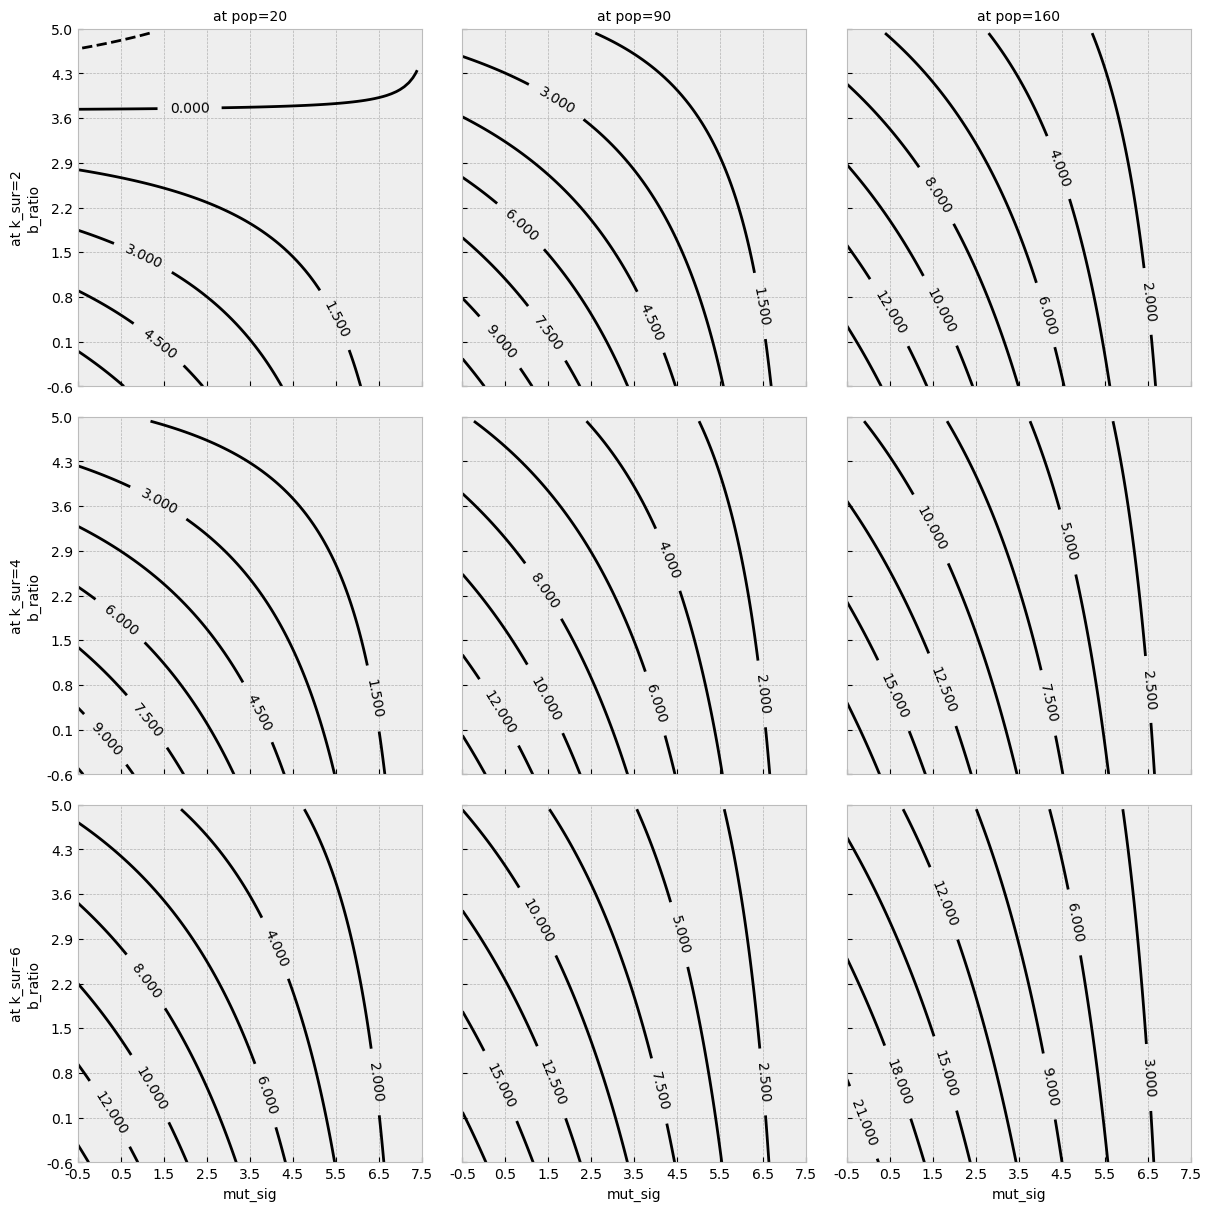

In [77]:
%%time
fig, axs = plt.subplots(
    figsize=(12, 12),
    nrows=3,
    ncols=3,
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
pop_plot_list = [-1, 0, 1]
k_sur_plot_list = [-1, 0, 1]

cx_pb_plot = 0
k_par_plot = 0
mut_pb_plot = 0

delta = 0.025
mut_sig_x = np.arange(-1.0, 1.0, delta)
b_ratio_y = np.arange(-1.0, 1.0, delta)
X, Y = np.meshgrid(mut_sig_x, b_ratio_y)

pop_title = [20, 90, 160]
k_sur_title = [2, 4, 6]

for i, row in enumerate(axs):
    for j, cell in enumerate(row):
        Z = pred_1_2(
            pop_plot_list[j],
            Y,
            cx_pb_plot,
            mut_pb_plot,
            X,
            k_par_plot,
            k_sur_plot_list[i],
        )
        ax = axs[i, j]
        CS = ax.contour(X, Y, Z, colors="black")
        ax.clabel(CS, inline=1, fontsize=10)
        if i == 0:
            cell.set_title("at pop=" + str(pop_title[j]), fontsize="medium")
        if i == len(axs) - 1:
            cell.set_xlabel("mut_sig", fontsize="medium")
            mut_sig_map = np.linspace(-0.5, 7.5, 9)
            mut_sig_map = [round(elem, 1) for elem in mut_sig_map]
            ax.set_xticklabels(mut_sig_map)
        if j == 0:
            cell.set_ylabel(
                "at k_sur=" + str(k_sur_title[i]) + "\n" + "b_ratio", fontsize="medium"
            )
            b_ratio_map = np.linspace(-0.6, 5.0, 9)
            b_ratio_map = [round(elem, 1) for elem in b_ratio_map]
            ax.set_yticklabels(b_ratio_map)

axs[0, 0].set_ylim((-1, 1))
axs[0, 0].set_xlim((-1, 1))

In [69]:
x_map = np.arange(-0.6, 5.0, 9)
x_map

array([-0.6])

# Visualization of data

Average value of minimum fitness for each generation

In [80]:
fit_log_file = pickle_dir + file_sufix + "_fit_log_df_80k.xz"
fit_log_df = pd.read_pickle(fit_log_file)

In [81]:
fit_log_df.head()

,exp,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,rep,seed,births,avg,best,med,std,worst
0,1,20,0.6,0.1,0.1,0.5,2,2,1,654,20,56.981337,28.234077,55.320931,9.969531,73.705843
1,1,20,0.6,0.1,0.1,0.5,2,2,1,654,32,51.011130,28.234077,52.211091,9.545410,62.532887
2,1,20,0.6,0.1,0.1,0.5,2,2,1,654,44,43.891616,28.234077,45.812904,9.859161,62.342473
3,1,20,0.6,0.1,0.1,0.5,2,2,1,654,56,36.421799,28.011376,34.236454,7.879449,50.157376
4,1,20,0.6,0.1,0.1,0.5,2,2,1,654,68,31.720135,28.011376,28.234077,5.486985,42.502718


Wall time: 47min 48s
Parser   : 221 ms


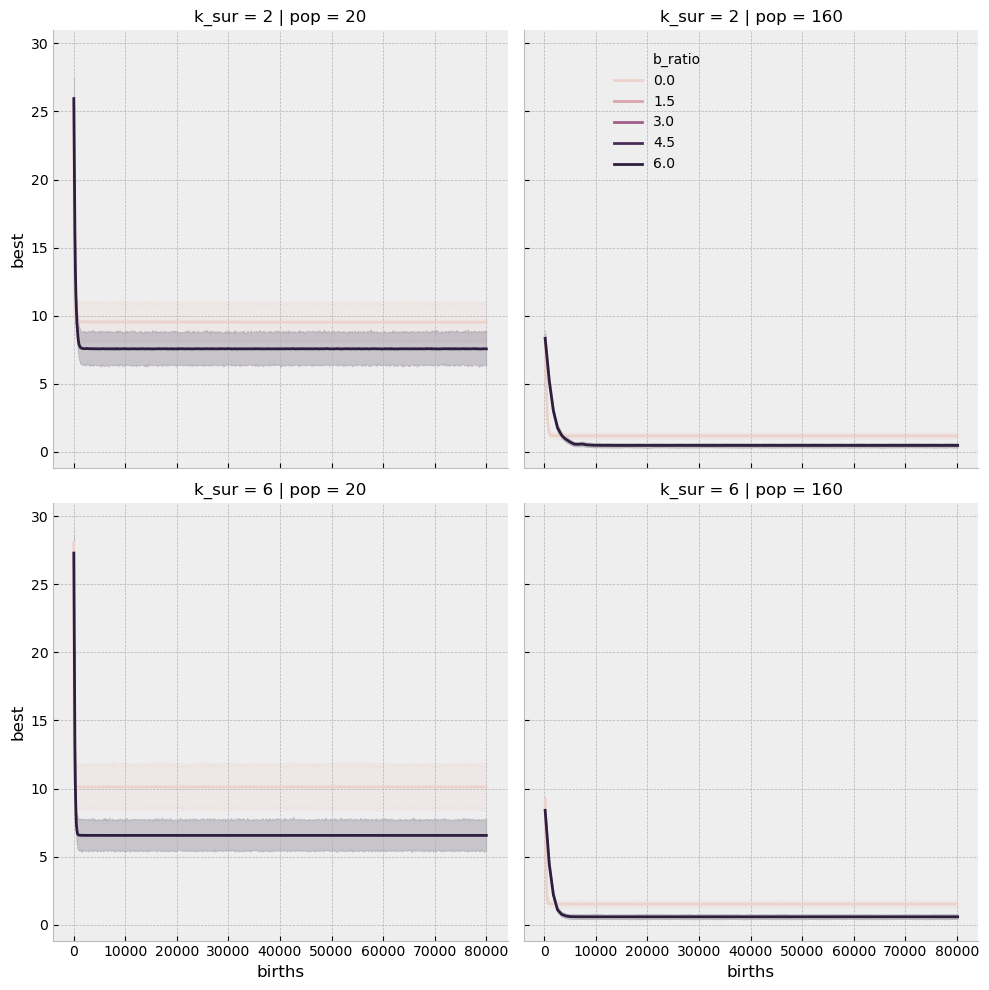

In [82]:
%%time
g = sns.relplot(
    x="births",
    y="best",
    col="pop",
    row="k_sur",
    hue="b_ratio",
    kind="line",
    data=fit_log_df[fit_log_df["mut_sig"] == 0.5],
)

leg = g._legend
leg.set_bbox_to_anchor([0.65, 0.95])
leg._loc = 1